## Visualization example

In [7]:
# %%bash
# source activate VQTrans

# python

# # change the text here
clip_text = ["a person is raising their left hand up"]




import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/VQTransformer_corruption05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')

## load clip model and datasets
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False, download_root='./')  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)


trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code,
                                embed_dim=1024,
                                clip_dim=args.clip_dim,
                                block_size=args.block_size,
                                num_layers=9,
                                n_head=16,
                                drop_out_rate=args.drop_out_rate,
                                fc_rate=args.ff_rate)


print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

print ('loading transformer checkpoint from {}'.format(args.resume_trans))
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()

mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model.encode_text(text).float()
index_motion = trans_encoder.sample(feat_clip_text[0:1], False)
pred_pose = net.forward_decoder(index_motion)

from utils.motion_process import recover_from_ric
pred_xyz = recover_from_ric((pred_pose*std+mean).float(), 22)
xyz = pred_xyz.reshape(1, -1, 22, 3)

np.save('motion.npy', xyz.detach().cpu().numpy())



loading checkpoint from pretrained/VQVAE/net_last.pth
loading transformer checkpoint from pretrained/VQTransformer_corruption05/net_best_fid.pth


In [8]:
from IPython.display import HTML
import base64



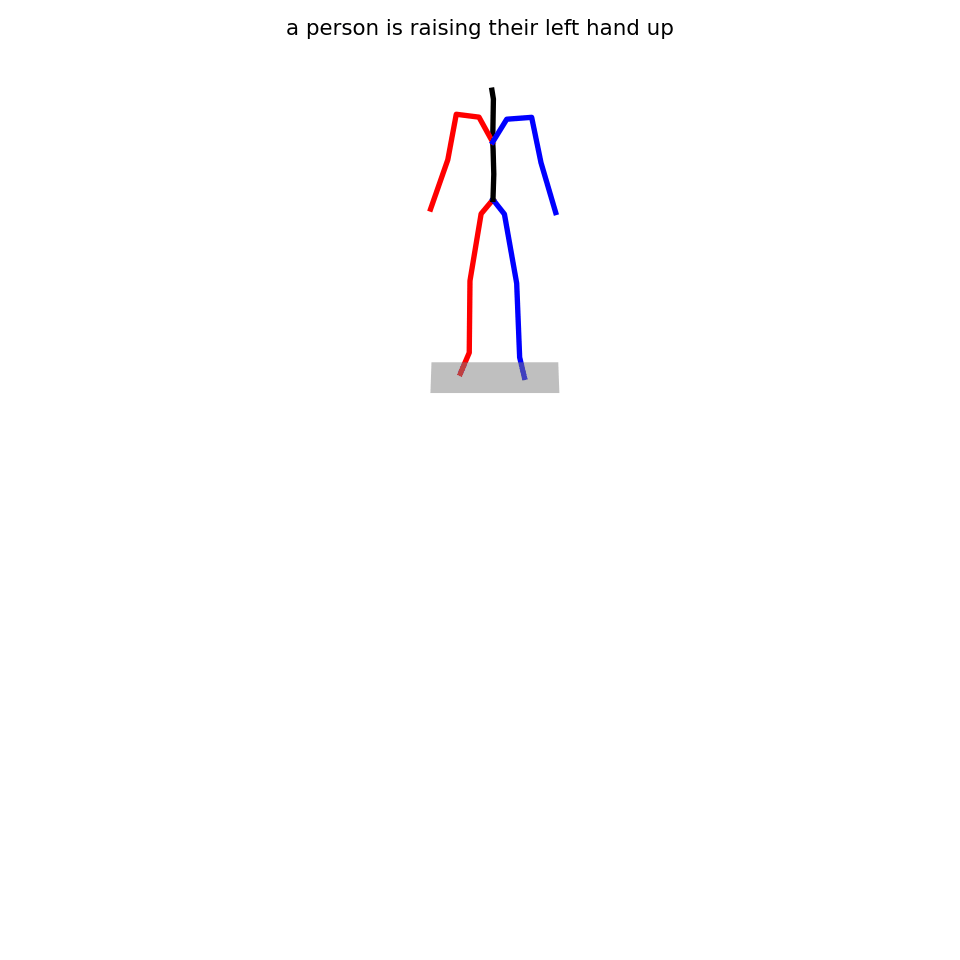

In [9]:

import visualization.plot_3d_global as plot_3d
pose_vis = plot_3d.draw_to_batch(xyz.detach().cpu().numpy(),clip_text, ['example.gif'])
b64 = base64.b64encode(open('example.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [7]:
xyz[0,0,:,:]

tensor([[ 0.0000e+00,  9.6486e-01,  0.0000e+00],
        [ 5.6471e-02,  8.8073e-01, -1.2292e-02],
        [-6.0427e-02,  8.7506e-01, -1.2111e-02],
        [ 8.3285e-04,  1.0906e+00, -4.2848e-02],
        [ 1.1268e-01,  4.9284e-01, -3.6395e-02],
        [-1.1379e-01,  4.8856e-01, -4.4950e-02],
        [ 3.1496e-03,  1.2293e+00, -1.6867e-02],
        [ 1.0379e-01,  6.4751e-02, -8.7953e-02],
        [-9.9990e-02,  6.9285e-02, -9.2105e-02],
        [ 2.4110e-03,  1.2866e+00, -1.5435e-02],
        [ 1.6283e-01,  9.8706e-03,  2.9742e-02],
        [-1.6023e-01,  1.0619e-02,  3.1954e-02],
        [-1.0469e-03,  1.5041e+00, -4.1806e-02],
        [ 7.7435e-02,  1.4004e+00, -3.1278e-02],
        [-7.7559e-02,  1.4044e+00, -3.6244e-02],
        [ 1.9155e-03,  1.5849e+00,  1.8096e-02],
        [ 1.9527e-01,  1.4522e+00, -5.2560e-02],
        [-1.8791e-01,  1.4560e+00, -5.4305e-02],
        [ 4.5601e-01,  1.4473e+00, -5.6044e-02],
        [-4.6395e-01,  1.4521e+00, -6.3241e-02],
        [ 6.9532e-01